In [1]:
import librosa as lb
import librosa.display
import scipy
import json
import numpy as np
import sklearn
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import os
import keras
from keras.utils import np_utils
from keras import layers
from keras import models
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from model_builder import build_example
from plotter import plot_history
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# CONSTANTS

DATA_DIR = "openmic-2018/"
CATEGORY_COUNT = 8
LEARNING_RATE = 0.00001
THRESHOLD = 0.5

In [15]:
# MEL-SPECTOGRAM EXAMPLE

y, sr = lb.load(DATA_DIR + 'audio/000/000135_483840.ogg')
S = lb.feature.melspectrogram(y=y, sr=sr)

S_dB = lb.power_to_db(S, ref=0) # 10 * log10(S / ref)


print(y.shape)
print(sr)
print(S.shape)
print(S_dB.shape)

librosa.display.specshow(S_dB, x_axis='s', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\hjani\\Documents\\Coding\\labor\\instrument-recognition-lab\\openmic-2018\\audio\\000\\000135_483840.ogg'

In [ ]:
MEL = []
sum = 0
for i in range(X.shape[0]):
    key = sample_key[i]
    key_pref = key[:3]
    y, sr = lb.load(DATA_DIR + 'audio/' + key_pref + '/' + key + '.ogg')
    S = lb.feature.melspectrogram(y=y, sr=sr)
    S_dB = lb.power_to_db(S, ref=0)
    MEL.append(S_dB[:,:430])
    


In [ ]:
MEL_S = np.asarray(MEL)
print('Mel has shape: ' + str(MEL_S.shape))

In [ ]:
# TODO SAVE WITHOUT X

np.savez('openmic-test-delete.npz', MEL = X, Y_true=Y_true, Y_mask=Y_mask, sample_key=sample_key)

In [ ]:
np.savez_compressed('openmic-mel-only.npz', MEL = MEL_S)
print('OpenMIC keys: ' + str(list(OPENMIC_2.keys())))

In [3]:

OPENMIC_2 = np.load(os.path.join(DATA_DIR, 'openmic-mel.npz'), allow_pickle=True)
X, Y_true, Y_mask, sample_key = OPENMIC_2['MEL'], OPENMIC_2['Y_true'], OPENMIC_2['Y_mask'], OPENMIC_2['sample_key']


In [8]:
# LOAD DATA

OPENMIC = np.load(os.path.join(DATA_DIR, 'openmic-mel.npz'), allow_pickle=True)
print('OpenMIC keys: ' + str(list(OPENMIC.keys())))
X, Y_true, Y_mask, sample_key = OPENMIC['MEL'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']
print('X has shape: ' + str(X.shape))
print('Y_true has shape: ' + str(Y_true.shape))
print('Y_mask has shape: ' + str(Y_mask.shape))
print('sample_key has shape: ' + str(sample_key.shape))

OpenMIC keys: ['MEL', 'Y_true', 'Y_mask', 'sample_key']
X has shape: (20000, 128, 430)
Y_true has shape: (20000, 20)
Y_mask has shape: (20000, 20)
sample_key has shape: (20000,)


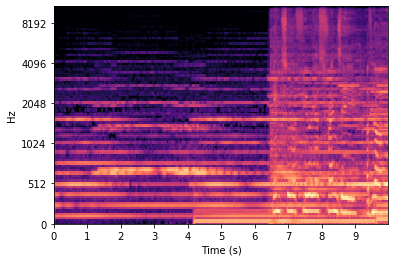

In [18]:
XX = lb.util.normalize(X[0])
librosa.display.specshow(X[0], x_axis='s', y_axis='mel')
#librosa.display.specshow(XX, x_axis='s', y_axis='mel')

In [19]:
XX

array([[0.8530154 , 0.71893799, 0.64315574, ..., 0.79318744, 0.75465075,
        0.7654445 ],
       [0.88860948, 0.81460939, 0.73923838, ..., 0.79572774, 0.79919508,
        0.79963716],
       [0.99105968, 0.89301696, 0.81325237, ..., 0.92902074, 0.92764764,
        0.93072276],
       ...,
       [0.68367004, 0.52095381, 0.46934916, ..., 0.62091283, 0.64284876,
        0.64765872],
       [0.68367004, 0.52095381, 0.46934916, ..., 0.56618223, 0.59860045,
        0.60921327],
       [0.68367004, 0.52095381, 0.46934916, ..., 0.45925261, 0.49411785,
        0.50425225]])

In [4]:
# LOAD LABELS

with open(os.path.join(DATA_DIR, 'class-map.json'), 'r') as f:
    INSTRUMENTS = json.load(f)
print('OpenMIC instruments: ' + str(INSTRUMENTS))

OpenMIC instruments: {'accordion': 0, 'banjo': 1, 'bass': 2, 'cello': 3, 'clarinet': 4, 'cymbals': 5, 'drums': 6, 'flute': 7, 'guitar': 8, 'mallet_percussion': 9, 'mandolin': 10, 'organ': 11, 'piano': 12, 'saxophone': 13, 'synthesizer': 14, 'trombone': 15, 'trumpet': 16, 'ukulele': 17, 'violin': 18, 'voice': 19}


In [5]:
# SPLIT DATA (TRAIN - TEST - VAL)

# CHANGE X TO MEL
split_train, split_test, X_train, X_test, Y_true_train, Y_true_test, Y_mask_train, Y_mask_test = train_test_split(sample_key, X, Y_true, Y_mask)
split_val, split_test, X_val, X_test, Y_true_val, Y_true_test, Y_mask_val, Y_mask_test = train_test_split(split_test, X_test, Y_true_test, Y_mask_test, test_size=0.5)
train_set = np.asarray(set(split_train))
test_set = np.asarray(set(split_test))
print('# Train: {}, # Val: {}, # Test: {}'.format(len(split_train), len(split_test), len(split_val)))

# Train: 15000, # Val: 2500, # Test: 2500


In [34]:
# DUPLICATE OF THE MODEL PREPROCESS

print(X_train.shape)
print(X_test.shape)

for instrument in INSTRUMENTS:
    
    # Map the instrument name to its column number
    inst_num = INSTRUMENTS[instrument]

    print(instrument)
    
    # TRAIN
    train_inst = Y_mask_train[:, inst_num]
    X_train_inst = X_train[train_inst]
    X_train_inst = X_train_inst.astype('float16')
    shape = X_train_inst.shape
    X_train_inst = X_train_inst.reshape(shape[0],1, shape[1], shape[2])
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= THRESHOLD
    i = 0
    for val in Y_true_train_inst:
        i += val
        
    print('TRAIN: ' + str(i) + ' true of ' + str(len(Y_true_train_inst)) + ' (' + str(round(i / len(Y_true_train_inst ) * 100,2)) + ' %)' )
        
    
    # TEST
    test_inst = Y_mask_test[:, inst_num]
    X_test_inst = X_test[test_inst]
    X_test_inst = X_test_inst.astype('float16')
    shape = X_test_inst.shape
    X_test_inst = X_test_inst.reshape(shape[0],1, shape[1], shape[2])
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= THRESHOLD
    
    i = 0
    for val in Y_true_test_inst:
        i += val
        
    print('TEST: ' + str(i) + ' true of ' + str(len(Y_true_test_inst)) + ' (' + str(round(i / len(Y_true_test_inst ) * 100,2)) + ' %)' )
    
    
    # VALIDATION
    val_inst = Y_mask_val[:, inst_num]
    X_val_inst = X_val[val_inst]
    X_val_inst = X_val_inst.astype('float16')
    shape = X_val_inst.shape
    X_val_inst = X_val_inst.reshape(shape[0],1, shape[1], shape[2])
    Y_true_val_inst = Y_true_val[val_inst, inst_num] >= THRESHOLD
    
    
    i = 0
    for val in Y_true_val_inst:
        i += val
    print('VALIDATION: ' + str(i) + ' true of ' + str(len(Y_true_val_inst)) + ' (' + str(round(i / len(Y_true_val_inst ) * 100,2)) + ' %)' )

(15000, 128, 430)
(2500, 128, 430)
accordion
TRAIN: 367 true of 1540 (23.83 %)
TEST: 64 true of 279 (22.94 %)
VALIDATION: 58 true of 252 (23.02 %)
banjo
TRAIN: 532 true of 1620 (32.84 %)
TEST: 99 true of 307 (32.25 %)
VALIDATION: 101 true of 291 (34.71 %)
bass
TRAIN: 410 true of 1401 (29.26 %)
TEST: 65 true of 234 (27.78 %)
VALIDATION: 74 true of 253 (29.25 %)
cello
TRAIN: 643 true of 1490 (43.15 %)
TEST: 97 true of 243 (39.92 %)
VALIDATION: 84 true of 216 (38.89 %)
clarinet
TRAIN: 411 true of 1810 (22.71 %)
TEST: 59 true of 293 (20.14 %)
VALIDATION: 63 true of 282 (22.34 %)
cymbals
TRAIN: 816 true of 1280 (63.75 %)
TEST: 144 true of 225 (64.0 %)
VALIDATION: 151 true of 230 (65.65 %)
drums
TRAIN: 827 true of 1313 (62.99 %)
TEST: 144 true of 226 (63.72 %)
VALIDATION: 135 true of 208 (64.9 %)
flute
TRAIN: 484 true of 1562 (30.99 %)
TEST: 82 true of 277 (29.6 %)
VALIDATION: 81 true of 245 (33.06 %)
guitar
TRAIN: 859 true of 1232 (69.72 %)
TEST: 147 true of 215 (68.37 %)
VALIDATION: 132 tr

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1519 samples, validate on 271 samples
Epoch 1/10
1519/1519 [==============================] - 243s 160ms/step - loss: 1.4823 - acc: 0.6432 - val_loss: 0.8994 - val_acc: 0.7638
Epoch 2/10
1519/1519 [==============================] - 233s 154ms/step - loss: 0.9874 - acc: 0.6853 - val_loss: 0.7584 - val_acc: 0.7638
Epoch 3/10
1519/1519 [==============================] - 232s 153ms/step - loss: 0.8897 - acc: 0.6801 - val_loss: 0.5379 - val_acc: 0.7712
Epoch 4/10
1519/1519 [==============================] - 231s 152ms/step - loss: 0.8063 - acc: 0.6814 - val_loss: 0.6440 - val_acc: 0.7638
Epoch 5/10
1519/1519 [==============================] - 239s 157ms/step - loss: 0.7674 - acc: 0.6748 - val_loss: 0.5574 - val_acc: 0.7638
Epoch 6/10
1519/1519 [======

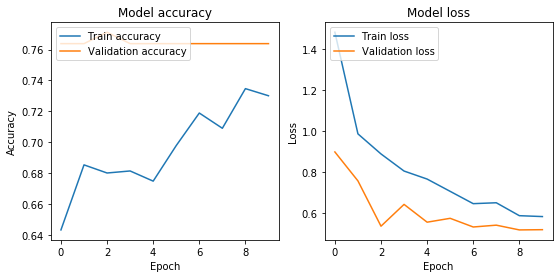

281/281 [==============================] - 17s 61ms/step
Test loss: 0.5738391290780064
Test accuracy: 75.09%
----------------------------------------------------
accordion
	TRAIN
              precision    recall  f1-score   support

       False       0.77      0.98      0.86      1164
        True       0.47      0.07      0.12       355

    accuracy                           0.76      1519
   macro avg       0.62      0.52      0.49      1519
weighted avg       0.70      0.76      0.69      1519

	TEST
              precision    recall  f1-score   support

       False       0.75      0.97      0.85       211
        True       0.30      0.04      0.07        70

    accuracy                           0.74       281
   macro avg       0.53      0.50      0.46       281
weighted avg       0.64      0.74      0.65       281

Train on 1687 samples, validate on 253 samples
Epoch 1/10
1687/1687 [==============================] - 285s 169ms/step - loss: 1.6191 - acc: 0.5756 - val_loss: 1

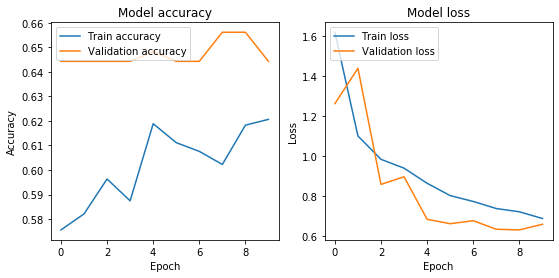

278/278 [==============================] - 18s 66ms/step
Test loss: 0.6368379172661321
Test accuracy: 66.55%
----------------------------------------------------
banjo
	TRAIN
              precision    recall  f1-score   support

       False       0.69      0.93      0.79      1138
        True       0.48      0.13      0.20       549

    accuracy                           0.67      1687
   macro avg       0.58      0.53      0.50      1687
weighted avg       0.62      0.67      0.60      1687

	TEST
              precision    recall  f1-score   support

       False       0.66      0.89      0.76       185
        True       0.32      0.11      0.16        93

    accuracy                           0.63       278
   macro avg       0.49      0.50      0.46       278
weighted avg       0.55      0.63      0.56       278

Train on 1416 samples, validate on 224 samples
Epoch 1/10
1416/1416 [==============================] - 244s 172ms/step - loss: 1.5489 - acc: 0.5798 - val_loss: 0.639

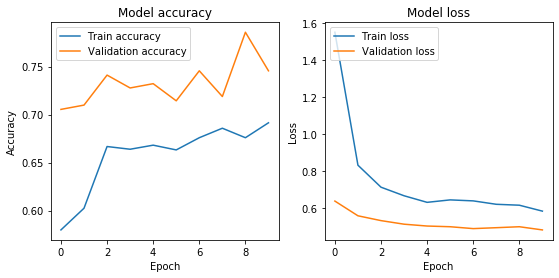

248/248 [==============================] - 15s 62ms/step
Test loss: 0.48448632417186616
Test accuracy: 76.61%
----------------------------------------------------
bass
	TRAIN
              precision    recall  f1-score   support

       False       0.83      0.71      0.77      1003
        True       0.48      0.65      0.55       413

    accuracy                           0.70      1416
   macro avg       0.66      0.68      0.66      1416
weighted avg       0.73      0.70      0.71      1416

	TEST
              precision    recall  f1-score   support

       False       0.89      0.79      0.83       178
        True       0.58      0.74      0.65        70

    accuracy                           0.77       248
   macro avg       0.73      0.76      0.74       248
weighted avg       0.80      0.77      0.78       248

Train on 1469 samples, validate on 236 samples
Epoch 1/10
1469/1469 [==============================] - 254s 173ms/step - loss: 1.7556 - acc: 0.5317 - val_loss: 0.734

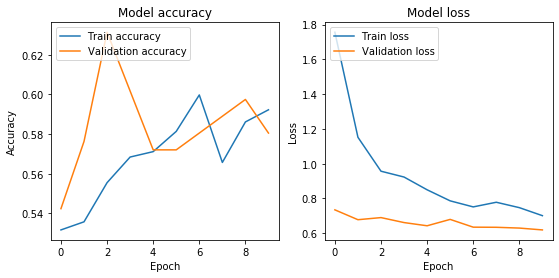

244/244 [==============================] - 15s 60ms/step
Test loss: 0.5947532761292379
Test accuracy: 65.16%
----------------------------------------------------
cello
	TRAIN
              precision    recall  f1-score   support

       False       0.77      0.53      0.63       843
        True       0.56      0.79      0.65       626

    accuracy                           0.64      1469
   macro avg       0.66      0.66      0.64      1469
weighted avg       0.68      0.64      0.64      1469

	TEST
              precision    recall  f1-score   support

       False       0.83      0.52      0.64       145
        True       0.55      0.84      0.66        99

    accuracy                           0.65       244
   macro avg       0.69      0.68      0.65       244
weighted avg       0.71      0.65      0.65       244

Train on 1758 samples, validate on 311 samples
Epoch 1/10
1758/1758 [==============================] - 281s 160ms/step - loss: 1.1186 - acc: 0.6593 - val_loss: 0.477

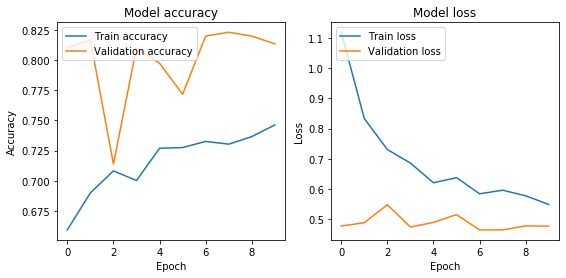

316/316 [==============================] - 17s 55ms/step
Test loss: 0.5168347962294952
Test accuracy: 75.32%
----------------------------------------------------
clarinet
	TRAIN
              precision    recall  f1-score   support

       False       0.80      0.87      0.83      1357
        True       0.37      0.26      0.31       401

    accuracy                           0.73      1758
   macro avg       0.59      0.57      0.57      1758
weighted avg       0.70      0.73      0.71      1758

	TEST
              precision    recall  f1-score   support

       False       0.80      0.86      0.83       240
        True       0.43      0.34      0.38        76

    accuracy                           0.73       316
   macro avg       0.62      0.60      0.61       316
weighted avg       0.72      0.73      0.72       316

Train on 1292 samples, validate on 229 samples
Epoch 1/10
1292/1292 [==============================] - 207s 160ms/step - loss: 1.8346 - acc: 0.5457 - val_loss: 0.

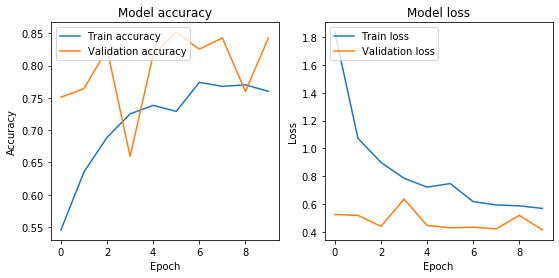

214/214 [==============================] - 13s 59ms/step
Test loss: 0.3548090073549859
Test accuracy: 84.11%
----------------------------------------------------
cymbals
	TRAIN
              precision    recall  f1-score   support

       False       0.94      0.65      0.77       468
        True       0.83      0.98      0.90       824

    accuracy                           0.86      1292
   macro avg       0.88      0.81      0.83      1292
weighted avg       0.87      0.86      0.85      1292

	TEST
              precision    recall  f1-score   support

       False       0.88      0.59      0.71        74
        True       0.82      0.96      0.88       140

    accuracy                           0.83       214
   macro avg       0.85      0.78      0.80       214
weighted avg       0.84      0.83      0.82       214

Train on 1284 samples, validate on 236 samples
Epoch 1/10
1284/1284 [==============================] - 206s 160ms/step - loss: 1.1872 - acc: 0.5717 - val_loss: 0.6

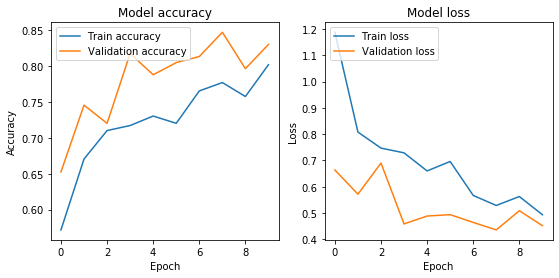

227/227 [==============================] - 13s 57ms/step
Test loss: 0.5031188363414504
Test accuracy: 82.38%
----------------------------------------------------
drums
	TRAIN
              precision    recall  f1-score   support

       False       0.90      0.72      0.80       466
        True       0.86      0.95      0.90       818

    accuracy                           0.87      1284
   macro avg       0.88      0.84      0.85      1284
weighted avg       0.87      0.87      0.87      1284

	TEST
              precision    recall  f1-score   support

       False       0.91      0.67      0.77        91
        True       0.81      0.96      0.88       136

    accuracy                           0.84       227
   macro avg       0.86      0.81      0.83       227
weighted avg       0.85      0.84      0.84       227

Train on 1577 samples, validate on 250 samples
Epoch 1/10
1577/1577 [==============================] - 254s 161ms/step - loss: 1.2625 - acc: 0.5802 - val_loss: 1.164

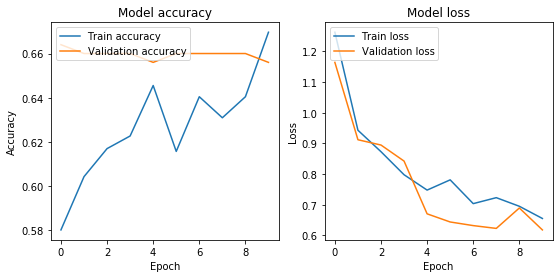

257/257 [==============================] - 15s 56ms/step
Test loss: 0.6230789652594333
Test accuracy: 66.15%
----------------------------------------------------
flute
	TRAIN
              precision    recall  f1-score   support

       False       0.73      0.84      0.78      1094
        True       0.44      0.30      0.36       483

    accuracy                           0.67      1577
   macro avg       0.59      0.57      0.57      1577
weighted avg       0.64      0.67      0.65      1577

	TEST
              precision    recall  f1-score   support

       False       0.71      0.80      0.76       177
        True       0.40      0.29      0.33        80

    accuracy                           0.64       257
   macro avg       0.56      0.54      0.54       257
weighted avg       0.61      0.64      0.62       257

Train on 1275 samples, validate on 177 samples
Epoch 1/10
1275/1275 [==============================] - 203s 159ms/step - loss: 2.0818 - acc: 0.5757 - val_loss: 0.732

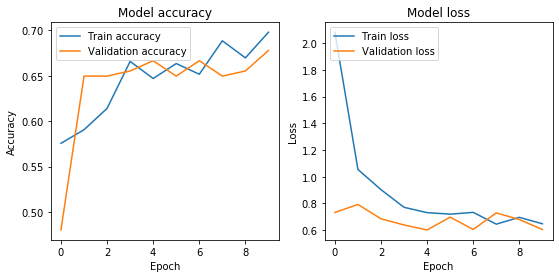

198/198 [==============================] - 13s 65ms/step
Test loss: 0.5209842715600524
Test accuracy: 73.74%
----------------------------------------------------
guitar
	TRAIN
              precision    recall  f1-score   support

       False       1.00      0.03      0.06       387
        True       0.70      1.00      0.83       888

    accuracy                           0.71      1275
   macro avg       0.85      0.52      0.44      1275
weighted avg       0.79      0.71      0.59      1275

	TEST
              precision    recall  f1-score   support

       False       1.00      0.05      0.09        63
        True       0.69      1.00      0.82       135

    accuracy                           0.70       198
   macro avg       0.85      0.52      0.45       198
weighted avg       0.79      0.70      0.59       198

Train on 1362 samples, validate on 214 samples
Epoch 1/10
1362/1362 [==============================] - 231s 170ms/step - loss: 1.8103 - acc: 0.5198 - val_loss: 0.73

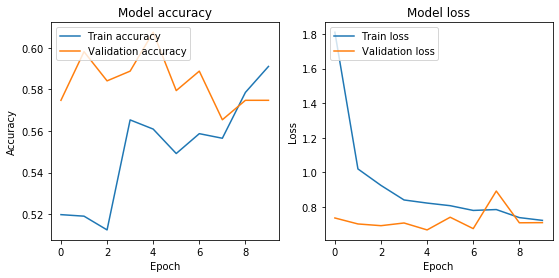

226/226 [==============================] - 15s 65ms/step
Test loss: 0.6503403548118287
Test accuracy: 63.72%
----------------------------------------------------
mallet_percussion
	TRAIN
              precision    recall  f1-score   support

       False       0.66      0.79      0.72       810
        True       0.57      0.41      0.48       552

    accuracy                           0.64      1362
   macro avg       0.62      0.60      0.60      1362
weighted avg       0.63      0.64      0.62      1362

	TEST
              precision    recall  f1-score   support

       False       0.65      0.75      0.70       137
        True       0.50      0.38      0.43        89

    accuracy                           0.61       226
   macro avg       0.58      0.57      0.57       226
weighted avg       0.59      0.61      0.59       226

Train on 1842 samples, validate on 311 samples
Epoch 1/10
1842/1842 [==============================] - 317s 172ms/step - loss: 0.9336 - acc: 0.5635 - val

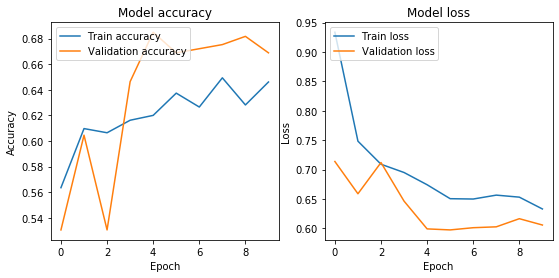

311/311 [==============================] - 19s 61ms/step
Test loss: 0.6496247246717717
Test accuracy: 60.13%
----------------------------------------------------
mandolin
	TRAIN
              precision    recall  f1-score   support

       False       0.78      0.65      0.71      1216
        True       0.48      0.63      0.55       626

    accuracy                           0.65      1842
   macro avg       0.63      0.64      0.63      1842
weighted avg       0.68      0.65      0.65      1842

	TEST
              precision    recall  f1-score   support

       False       0.67      0.62      0.65       192
        True       0.46      0.51      0.48       119

    accuracy                           0.58       311
   macro avg       0.57      0.57      0.57       311
weighted avg       0.59      0.58      0.59       311

Train on 1416 samples, validate on 224 samples
Epoch 1/10
1416/1416 [==============================] - 252s 178ms/step - loss: 1.7002 - acc: 0.6010 - val_loss: 0.

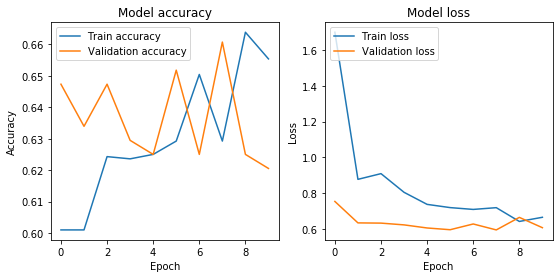

250/250 [==============================] - 16s 63ms/step
Test loss: 0.5691616973876953
Test accuracy: 70.40%
----------------------------------------------------
organ
	TRAIN
              precision    recall  f1-score   support

       False       0.92      0.44      0.60       968
        True       0.43      0.92      0.59       448

    accuracy                           0.59      1416
   macro avg       0.68      0.68      0.59      1416
weighted avg       0.77      0.59      0.59      1416

	TEST
              precision    recall  f1-score   support

       False       0.96      0.42      0.59       173
        True       0.43      0.96      0.59        77

    accuracy                           0.59       250
   macro avg       0.69      0.69      0.59       250
weighted avg       0.80      0.59      0.59       250

Train on 1310 samples, validate on 206 samples
Epoch 1/10
1310/1310 [==============================] - 224s 171ms/step - loss: 1.2964 - acc: 0.6260 - val_loss: 0.467

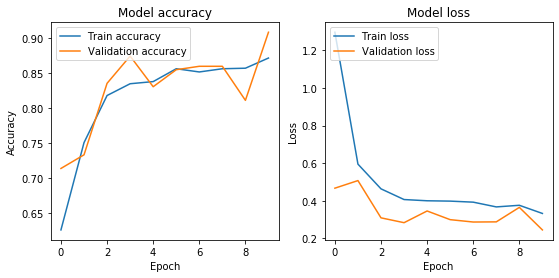

204/204 [==============================] - 14s 71ms/step
Test loss: 0.26010071734587353
Test accuracy: 90.20%
----------------------------------------------------
piano
	TRAIN
              precision    recall  f1-score   support

       False       0.95      0.67      0.78       419
        True       0.86      0.98      0.92       891

    accuracy                           0.88      1310
   macro avg       0.90      0.83      0.85      1310
weighted avg       0.89      0.88      0.88      1310

	TEST
              precision    recall  f1-score   support

       False       0.92      0.67      0.77        66
        True       0.86      0.97      0.91       138

    accuracy                           0.87       204
   macro avg       0.89      0.82      0.84       204
weighted avg       0.88      0.87      0.87       204

Train on 1742 samples, validate on 297 samples
Epoch 1/10
1742/1742 [==============================] - 292s 168ms/step - loss: 1.3059 - acc: 0.5103 - val_loss: 0.73

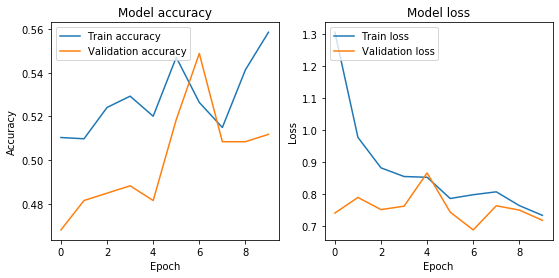

326/326 [==============================] - 20s 63ms/step
Test loss: 0.6907476643843153
Test accuracy: 55.83%
----------------------------------------------------
saxophone
	TRAIN
              precision    recall  f1-score   support

       False       0.65      0.35      0.46       914
        True       0.52      0.79      0.63       828

    accuracy                           0.56      1742
   macro avg       0.58      0.57      0.54      1742
weighted avg       0.59      0.56      0.54      1742

	TEST
              precision    recall  f1-score   support

       False       0.64      0.40      0.49       174
        True       0.52      0.74      0.61       152

    accuracy                           0.56       326
   macro avg       0.58      0.57      0.55       326
weighted avg       0.58      0.56      0.55       326

Train on 1212 samples, validate on 187 samples
Epoch 1/10
1212/1212 [==============================] - 193s 159ms/step - loss: 1.1954 - acc: 0.5883 - val_loss: 0

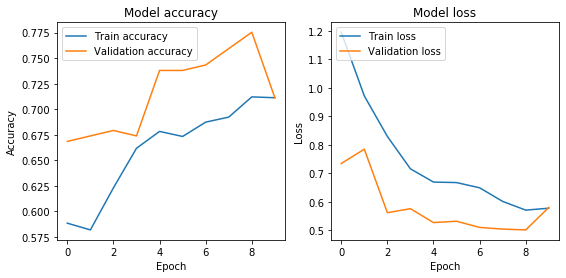

203/203 [==============================] - 12s 58ms/step
Test loss: 0.5563669988674483
Test accuracy: 70.94%
----------------------------------------------------
synthesizer
	TRAIN
              precision    recall  f1-score   support

       False       0.68      0.73      0.71       386
        True       0.87      0.84      0.85       826

    accuracy                           0.81      1212
   macro avg       0.78      0.79      0.78      1212
weighted avg       0.81      0.81      0.81      1212

	TEST
              precision    recall  f1-score   support

       False       0.61      0.67      0.64        64
        True       0.84      0.81      0.82       139

    accuracy                           0.76       203
   macro avg       0.73      0.74      0.73       203
weighted avg       0.77      0.76      0.77       203

Train on 2054 samples, validate on 367 samples
Epoch 1/10
2054/2054 [==============================] - 331s 161ms/step - loss: 1.9052 - acc: 0.5740 - val_loss:

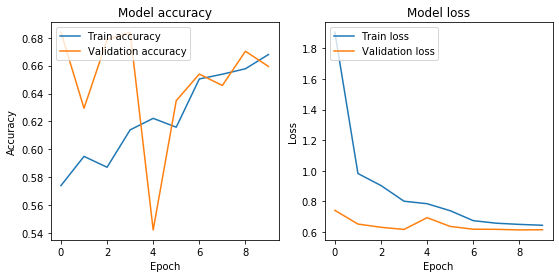

339/339 [==============================] - 23s 66ms/step
Test loss: 0.6200752998523655
Test accuracy: 66.96%
----------------------------------------------------
trombone
	TRAIN
              precision    recall  f1-score   support

       False       0.81      0.60      0.69      1415
        True       0.44      0.68      0.53       639

    accuracy                           0.63      2054
   macro avg       0.62      0.64      0.61      2054
weighted avg       0.69      0.63      0.64      2054

	TEST
              precision    recall  f1-score   support

       False       0.72      0.54      0.62       227
        True       0.38      0.58      0.46       112

    accuracy                           0.55       339
   macro avg       0.55      0.56      0.54       339
weighted avg       0.61      0.55      0.57       339

Train on 2156 samples, validate on 397 samples
Epoch 1/10
2156/2156 [==============================] - 425s 197ms/step - loss: 1.4412 - acc: 0.5301 - val_loss: 0.

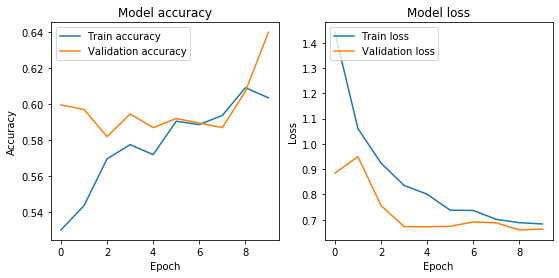

363/363 [==============================] - 23s 63ms/step
Test loss: 0.698793343604432
Test accuracy: 54.82%
----------------------------------------------------
trumpet
	TRAIN
              precision    recall  f1-score   support

       False       0.86      0.27      0.41      1324
        True       0.44      0.93      0.60       832

    accuracy                           0.52      2156
   macro avg       0.65      0.60      0.50      2156
weighted avg       0.70      0.52      0.48      2156

	TEST
              precision    recall  f1-score   support

       False       0.65      0.19      0.30       208
        True       0.44      0.86      0.58       155

    accuracy                           0.48       363
   macro avg       0.54      0.53      0.44       363
weighted avg       0.56      0.48      0.42       363

Train on 1827 samples, validate on 314 samples
Epoch 1/10
1827/1827 [==============================] - 332s 182ms/step - loss: 1.2970 - acc: 0.5862 - val_loss: 0.72

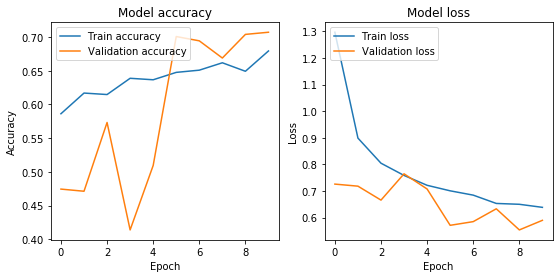

284/284 [==============================] - 18s 64ms/step
Test loss: 0.6137258754649633
Test accuracy: 65.85%
----------------------------------------------------
ukulele
	TRAIN
              precision    recall  f1-score   support

       False       0.86      0.33      0.48      1260
        True       0.37      0.88      0.52       567

    accuracy                           0.50      1827
   macro avg       0.61      0.60      0.50      1827
weighted avg       0.71      0.50      0.49      1827

	TEST
              precision    recall  f1-score   support

       False       0.87      0.35      0.50       204
        True       0.34      0.86      0.49        80

    accuracy                           0.50       284
   macro avg       0.61      0.61      0.50       284
weighted avg       0.72      0.50      0.50       284

Train on 1516 samples, validate on 260 samples
Epoch 1/10
1516/1516 [==============================] - 269s 177ms/step - loss: 2.3592 - acc: 0.5053 - val_loss: 0.6

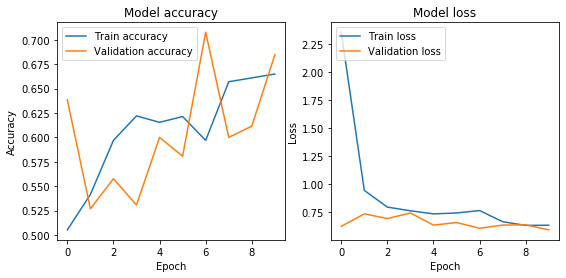

257/257 [==============================] - 17s 66ms/step
Test loss: 0.548202626436137
Test accuracy: 72.37%
----------------------------------------------------
violin
	TRAIN
              precision    recall  f1-score   support

       False       0.92      0.46      0.61       640
        True       0.71      0.97      0.82       876

    accuracy                           0.76      1516
   macro avg       0.82      0.72      0.72      1516
weighted avg       0.80      0.76      0.73      1516

	TEST
              precision    recall  f1-score   support

       False       0.93      0.39      0.55       106
        True       0.69      0.98      0.81       151

    accuracy                           0.74       257
   macro avg       0.81      0.68      0.68       257
weighted avg       0.79      0.74      0.70       257

Train on 1172 samples, validate on 193 samples
Epoch 1/10
1172/1172 [==============================] - 196s 167ms/step - loss: 1.8857 - acc: 0.5700 - val_loss: 0.689

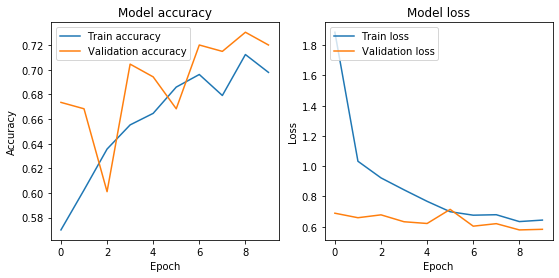

199/199 [==============================] - 14s 69ms/step
Test loss: 0.5129846924513428
Test accuracy: 77.89%
----------------------------------------------------
voice
	TRAIN
              precision    recall  f1-score   support

       False       0.91      0.40      0.55       437
        True       0.73      0.98      0.84       735

    accuracy                           0.76      1172
   macro avg       0.82      0.69      0.70      1172
weighted avg       0.80      0.76      0.73      1172

	TEST
              precision    recall  f1-score   support

       False       0.86      0.37      0.52        65
        True       0.76      0.97      0.85       134

    accuracy                           0.77       199
   macro avg       0.81      0.67      0.68       199
weighted avg       0.79      0.77      0.74       199



In [9]:
# This dictionary will include the classifiers for each model
mymodels = dict()
# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in INSTRUMENTS:
    
    # Map the instrument name to its column number
    inst_num = INSTRUMENTS[instrument]

    # Step 1: sub-sample the data
    # First, we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    
    # TRAIN
    train_inst = Y_mask_train[:, inst_num]
    X_train_inst = X_train[train_inst]
    X_train_inst = X_train_inst.astype('float16')
    shape = X_train_inst.shape
    X_train_inst = X_train_inst.reshape(shape[0],1, shape[1], shape[2])
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= THRESHOLD
    
    # TEST
    test_inst = Y_mask_test[:, inst_num]
    X_test_inst = X_test[test_inst]
    X_test_inst = X_test_inst.astype('float16')
    shape = X_test_inst.shape
    X_test_inst = X_test_inst.reshape(shape[0],1, shape[1], shape[2])
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= THRESHOLD
    
    # VALIDATION
    val_inst = Y_mask_val[:, inst_num]
    X_val_inst = X_val[val_inst]
    X_val_inst = X_val_inst.astype('float16')
    shape = X_val_inst.shape
    X_val_inst = X_val_inst.reshape(shape[0],1, shape[1], shape[2])
    Y_true_val_inst = Y_true_val[val_inst, inst_num] >= THRESHOLD
    

    # Step 3.
    # Initialize a new classifier
    model = models.Sequential()
    model.add(Conv2D(input_shape=(1,128,430),data_format="channels_first",filters=32,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=32,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(3,3),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=256, activation='relu'))
    model.add(layers.Dense(units=1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr= LEARNING_RATE), metrics = ['accuracy'])

    # model.summary()
    # Step 4.
    history = model.fit(X_train_inst,Y_true_train_inst , epochs=10, batch_size=64, validation_data=(X_val_inst,Y_true_val_inst))
    
    plot_history()
    
    loss, acc = model.evaluate(X_test_inst, Y_true_test_inst)
    print('Test loss: {}'.format(loss))
    print('Test accuracy: {:.2%}'.format(acc))
    # Step 5.
    # Finally, we'll evaluate the model on both train and test
    Y_pred_train = model.predict(X_train_inst)
    Y_pred_test = model.predict(X_test_inst)
    Y_pred_train_bool = Y_pred_train > THRESHOLD - 0.15 #THRESHOLD (should be lower than 0.5)
    Y_pred_test_bool = Y_pred_test > THRESHOLD - 0.15 #THRESHOLD (should be lower than 0.5)
    print('-' * 52)
    print(instrument)
    print('\tTRAIN')
    print(classification_report(Y_true_train_inst, Y_pred_train_bool))
    print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_bool))

    # Store the classifier in our dictionary
mymodels[instrument] = model

In [8]:

import matplotlib.pyplot as plt
from pylab import plot, show, figure, imshow, xlim, ylim, title


def plot_history():
    plt.figure(figsize=(9,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train accuracy', 'Validation accuracy'], loc='upper left')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper left')
    plt.show()

In [ ]:
""""
    # Step 3: simplify the data by averaging over time
    # Instead of having time-varying features, we'll summarize each track by its mean feature vector over time
    X_train_inst_sklearn = np.mean(X_train_inst, axis=1)
    X_test_inst_sklearn = np.mean(X_test_inst, axis=1)
    X_train_inst_sklearn = X_train_inst_sklearn.astype('float32')
    X_train_inst_sklearn = lb.util.normalize(X_train_inst_sklearn)
"""

np.savez('models.npz',model=)